## Project Initialization

In [21]:
# Load packages 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pickle
from progressbar import ProgressBar

## Data Pre-processing Steps

In [2]:
# Read in the dataset as data frame and get the basic information about the schema
course_df = pd.read_csv("Courses.csv")
course_df.head(5)

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired
0,enterprise-search-executive-briefing,Enterprise Search: Executive Briefing,1785,2020-12-28,For a company to remain competitive and effici...,None,no
1,troubleshooting-applications-cloud-foundry,Troubleshooting Applications in Cloud Foundry,5468,2020-12-25,"When it comes to application quality, the func...",None,no
2,sharepoint-online-administration-playbook,SharePoint Online Administration Playbook,6299,2020-12-24,Microsoft 365 is the most popular productivity...,None,no
3,microsoft-azure-iot-developer-implement-device...,Microsoft Azure IoT Developer: Implement the D...,2368,2020-12-23,The Microsoft Azure IoT Developer exam is for ...,None,no
4,build-first-dashboard-idashboards,Build Your First Dashboard with iDashboards,2679,2020-12-23,The ability to understand the story that a dat...,None,no


In [3]:
course_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12061 entries, 0 to 12060
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CourseId           12061 non-null  object
 1   CourseTitle        12061 non-null  object
 2   DurationInSeconds  12061 non-null  int64 
 3   ReleaseDate        12061 non-null  object
 4   Description        12061 non-null  object
 5   AssessmentStatus   12061 non-null  object
 6   IsCourseRetired    12061 non-null  object
dtypes: int64(1), object(6)
memory usage: 659.7+ KB


In [4]:
# Drop rows with NA, especially 'Description'
course_df = course_df.dropna(how='any')
course_df.shape

(12061, 7)

In [5]:
# Remove words like we'll, you'll, they'll 
course_df['Description'] = course_df['Description'].replace({"'ll": " "}, regex=True)

# Remove of '-' from the CourseId 
course_df['CourseId'] = course_df['CourseId'].replace({"-": " "}, regex=True)

# Combine three columns: CourseId, CourseTitle, Description
comb_frame = course_df.CourseId.str.cat(" "+course_df.CourseTitle.str.cat(" "+course_df.Description))

# Remove all characters except numbers and alphabets
comb_frame = comb_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

## Tf-idf Vectorizer

tf-idf is a text features engineering method that can be used to measure importance of a word by comparing the number of times a word appears in a doc with the number of docs the word appears in

tf-idf: Term Frequency - Inverse Document Frequency 

For example:
tf(t) = (Number of times term 't' appears in a specific document) / (Total number of terms in that document)
idf(t) = log_e((Total number of documents) / (Number of documents with term 't' in it))

A high weight in tf–idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)
print(X.shape) # There are 12061 documents, with 28020 unique single words

(12061, 28020)


In [7]:
type(X)

scipy.sparse.csr.csr_matrix

In [8]:
df_X = pd.DataFrame(X.toarray())
df_X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,28010,28011,28012,28013,28014,28015,28016,28017,28018,28019
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sample Model Training and Analysis

In [9]:
# First use k = 8, which represents the number of clusters in K Means Clustering
k = 8

# Running model with 15 different centroid initialization & maximum iterations are 500
model = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=15)
model.fit(X)

KMeans(max_iter=500, n_init=15)

In [10]:
# Top terms in each cluster
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 sharepoint
 2010
 2013
 conference
 server
 2019
 office
 2016
 microsoft
 site
 course
 online
 content
 365
 session
Cluster 1:
 windows
 server
 sql
 10
 course
 exchange
 configure
 2012
 2008
 administration
 powershell
 2016
 directory
 network
 active
Cluster 2:
 aws
 play
 amazon
 youll
 salesforce
 service
 course
 cloud
 services
 introduction
 security
 data
 iot
 learn
 applications
Cluster 3:
 azure
 microsoft
 youll
 services
 cloud
 solutions
 data
 course
 storage
 security
 learn
 knowledge
 exam
 applications
 service
Cluster 4:
 maya
 animation
 modeling
 required
 software
 character
 rendering
 rigging
 tutorial
 create
 techniques
 creating
 learn
 lighting
 using
Cluster 5:
 course
 learn
 youll
 security
 web
 applications
 code
 using
 use
 application
 cloud
 design
 knowledge
 session
 management
Cluster 6:
 data
 course
 youll
 big
 learn
 visualization
 using
 analytics
 analysis
 science
 knowledge
 sql
 use
 session
 dat

In [15]:
# Use the elbow-test method to find the ideal value of k
sse = {}

# Add progress bar in the for loop
pbar = ProgressBar()

for k in pbar(range(1,40)):
    kmeans = KMeans(n_clusters=k,init='k-means++',max_iter=100).fit(X)
    comb_frame["clusters"] = kmeans.labels_
    sse[k]= kmeans.inertia_

100% |########################################################################|


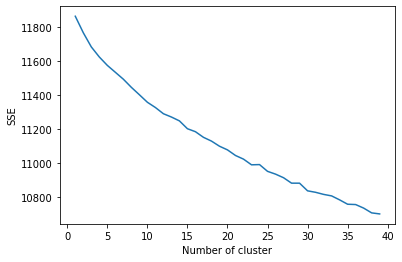

In [16]:
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
# Save the Plot in current directory
plt.savefig('elbow_method.png')

## Model Training with K = 30

In [17]:
# Running model with 15 different centroid initializations & maximum iterations are 500
k = 30
model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 500, n_init = 15)
model.fit(X)

KMeans(max_iter=500, n_clusters=30, n_init=15)

In [19]:
# Top 10 terms in each cluster
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 play
 salesforce
 unrehearsed
 unscripted
 technologists
 problem
 real
 lightning
 work
 time
Cluster 1:
 windows
 server
 10
 course
 configure
 2012
 directory
 active
 network
 configuring
Cluster 2:
 maya
 animation
 modeling
 required
 software
 rendering
 rigging
 tutorial
 create
 techniques
Cluster 3:
 security
 network
 secure
 information
 course
 cisco
 comptia
 cyber
 awareness
 risk
Cluster 4:
 testing
 tests
 test
 unit
 automated
 code
 ui
 write
 course
 penetration
Cluster 5:
 aws
 youll
 services
 cloud
 service
 introduction
 amazon
 course
 iot
 security
Cluster 6:
 zbrush
 sculpting
 character
 tutorial
 maya
 creature
 mesh
 required
 create
 creating
Cluster 7:
 course
 youll
 learn
 code
 applications
 use
 using
 fundamentals
 java
 programming
Cluster 8:
 data
 youll
 big
 course
 visualization
 learn
 using
 analysis
 analytics
 knowledge
Cluster 9:
 effects
 nuke
 software
 learn
 required
 create
 softimage
 revit
 3d
 ho

In [22]:
# Save machine learning model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Working Recommendation System

In [28]:
# Create function to predict the cluster of any description being inputted into it
def cluster_predict(str_input):
    Y = vectorizer.transform(list(str_input))
    prediction = model.predict(Y)
    return prediction

# Create new column for storing predicted categories from our trained model
course_df['ClusterPrediction'] = ""

# Load the complete data in a dataframe
courses_df = pd.read_csv("Courses.csv")

# Drop retired course from analysis
courses_df = courses_df[courses_df['IsCourseRetired'] == 'no']

# Create new column in dataframe which is combination of CourseId, CourseTitle, Description in existing dataframe
course_df['InputString'] = course_df.CourseId.str.cat(" "+course_df.CourseTitle.str.cat(" "+course_df.Description))

# Cluster category for each live course
course_df['ClusterPrediction'] = course_df.apply(lambda x: cluster_predict(course_df['InputString']), axis = 0)

course_df.head(5)

,CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired,ClusterPrediction,InputString
0,enterprise search executive briefing,Enterprise Search: Executive Briefing,1785,2020-12-28,For a company to remain competitive and effici...,None,no,8,enterprise search executive briefing Enterpris...
1,troubleshooting applications cloud foundry,Troubleshooting Applications in Cloud Foundry,5468,2020-12-25,"When it comes to application quality, the func...",None,no,7,troubleshooting applications cloud foundry Tro...
2,sharepoint online administration playbook,SharePoint Online Administration Playbook,6299,2020-12-24,Microsoft 365 is the most popular productivity...,None,no,17,sharepoint online administration playbook Shar...
3,microsoft azure iot developer implement device...,Microsoft Azure IoT Developer: Implement the D...,2368,2020-12-23,The Microsoft Azure IoT Developer exam is for ...,None,no,26,microsoft azure iot developer implement device...
4,build first dashboard idashboards,Build Your First Dashboard with iDashboards,2679,2020-12-23,The ability to understand the story that a dat...,None,no,8,build first dashboard idashboards Build Your F...


In [47]:
# The recommendation utility function will predict the course category and recommend few random courses
def recommend_util(str_input):
    
    # Predict category of input string category
    temp_df = course_df.loc[course_df['CourseId'] == str_input]

    temp_df['InputString'] = temp_df.CourseId.str.cat(" "+temp_df.CourseTitle.str.cat(" "+temp_df['Description']))

    str_input = list(temp_df['InputString'])

    prediction_inp = cluster_predict(str_input)
    prediction_inp = int(prediction_inp)
    
    temp_df = course_df.loc[course_df['ClusterPrediction'] == prediction_inp]
    temp_df = temp_df.sample(10)
    
    return list(temp_df['CourseId'])

In [49]:
# Test the recommendation utility function
queries = ['play by play machine learning exposed', 
           'microsoft cognitive services machine learning', 
           'python scikit learn building machine learning models', 
           'pandas data wrangling machine learning engineers', 
           'xgboost python scikit learn machine learning']

pd.set_option('mode.chained_assignment', None)

for query in queries:
    res = recommend_util(query)
    print(res)

['play by play customizing gradle with plugins', 'play by play windows clusters for beginners minasi', 'play by play chris hartjes', 'play by play zed shaw', 'play by play mvp scope discovery', 'play by play vms development care maintenance', 'play by play prototyping ux solutions lightning components', 'play by play penetration testers guide social engineering', 'play by play authenticating external app service integrations salesforce', 'play by play tim pope']
['launching machine learning', 'google machine learning apis designing implementing solutions', 'introduction aws machine learning services', 'build machine learning workflow keras tensorflow', 'pytorch building deep learning models', 'building image classification solutions keras transfer learning', 'leveraging online resources python analytics', 'microsoft ignite session 16', 'getting started nlp deep learning pytorch fastai', 'ng conf 19 machine learning tensorflow js']
['big data ldn 2020 machine learning autopilot', 'funda